# Malware Classification

**Instructions**:

Suppose your company is struggling with a series of computer virus attacks for the past several months. The viruses were grouped into a few types with some effort. However, it takes a long time to sort out what kind of virus it is when been hit with. Thus, as a senior IT department member, you undertook a project to classify the virus as quickly as possible. You've been given a dataset of the features that may be handy (or not), and also the associated virus type (target variable).

You are supposed to try different classification methods and apply best practices we have seen in the lectures such as grid search, cross validation, regularization etc. To increase your grade you can add more elaboration such as using ensembling or exploiting feature selection/extraction techniques. An evaluation rubric is provided.

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import GenericUnivariateSelect
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
df = pd.read_csv("Virus_Dataset.csv", delimiter=',')
df.shape

(4999, 1805)

In [ ]:
train_df, test_df, train_df_target, test_df_target = train_test_split(df.drop("target", axis=1), df["target"])
train_df.head()

,Virtual,Offset,loc,Import,Imports,var,Forwarder,UINT,LONG,BOOL,...,Img98,Img99,Img100,Img101,Img102,Img103,Img104,Img105,Img106,Img107
644,3.0,6.000000,39615.295122,30.0,10.0,23341.0,10.0,69.0,7.0,43.0,...,-39799.698332,222419.209166,-161317.298253,184203.226183,7997.953419,-11558.699429,-91616.581735,-70357.955334,72183.0,49237.0
3019,2.0,42254.056504,181.000000,0.0,0.0,272.0,0.0,0.0,0.0,0.0,...,1015.874472,-11287.744541,-89989.218992,75832.553870,12176.359016,-22841.056943,-235426.896741,109643.651062,10122.0,9580.0
4047,3.0,3.000000,1609.000000,18.0,6.0,232.0,6.0,27.0,1.0,26.0,...,114254.715787,-161133.701276,-85042.593740,-92845.562311,65079.462327,93289.297981,30861.185699,-150717.729987,11455.0,8828.0
195,2.0,2.000000,81.000000,12.0,4.0,5.0,4.0,29.0,18.0,84.0,...,28740.345030,-145172.893056,30732.198115,-30435.443578,101348.311505,128024.390631,743.118254,-97785.506771,58880.0,27315.0
4773,3.0,3.000000,14870.000000,6.0,2.0,5869.0,2.0,25.0,45.0,26.0,...,-132219.363543,-219428.496229,-67173.722829,-57958.830726,9092.223146,41426.236651,-166183.105379,109622.233169,28659.0,18398.0


I scaled the data using Standard Scaler for faster execution and more precision.

I used 4 different classification methods: Logistic Regression, Decision Tree, K Nearest Neighbors and Support Vector Machine.

I run all algorithms with default parameters and printed mean cross validation scores for comparison with each other and with the final score.

In [ ]:
tree = Pipeline([('scaling', StandardScaler()), ('model', DecisionTreeClassifier())])
knn = KNeighborsClassifier() # k=5
svm = Pipeline([('scaling', StandardScaler()), ('model', SVC())])
lr = Pipeline([('scaling', StandardScaler()), ('model', LogisticRegression(solver='liblinear'))])

In [ ]:
print("CV Scores With All Features\n")
print("Decision Tree Classifier: ", cross_val_score(tree, train_df, train_df_target, cv=3).mean())
print("K-Neighbors Classifier: ", cross_val_score(knn, train_df, train_df_target, cv=5).mean())
print("Support Vector Classification: ", cross_val_score(svm, train_df, train_df_target, cv=3).mean())
print("Logistic Regression: ", cross_val_score(lr, train_df, train_df_target, cv=3).mean())

CV Scores With All Features

Decision Tree Classifier:  0.7802062449959969
K-Neighbors Classifier:  0.7420589230084558
Support Vector Classification:  0.6033584200693888
Logistic Regression:  0.5212035228182547


# Feature Selection

In [ ]:
print("Number of features: ", train_df.shape[1])

Number of features:  1804


I used the filter method and mutual information statistics for feature selection.

I executed the feature sets with different number of features in all four algorithms and chose the feature set with the best performance in all of them with cross validation.

In [ ]:
ks = [50, 100, 250, 500, 720, 900, 1200]
feature_sets = []
feature_names_set = [] # stores selected feature names for each feature set
for k in ks:
  select = GenericUnivariateSelect(score_func=mutual_info_classif, mode="k_best", param=k)
  X_k = select.fit_transform(train_df, train_df_target)
  feature_names_set.append(select.get_feature_names_out())
  feature_sets.append(X_k)

In [ ]:
def draw_score(algorithm):
  # This function calculates the cross validation scores of the given algorithm
  # for feature sets with different lengths and draws a graph.
  acc = []
  for i in range(len(ks)):
    score = cross_val_score(algorithm, feature_sets[i], train_df_target, cv=3).mean()
    acc.append(score)

  plt.plot(ks, acc, linestyle="dotted", marker="o")
  plt.xlabel('Number of Features')
  plt.ylabel('CV Accuracy')

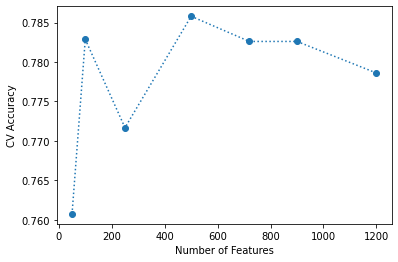

In [ ]:
draw_score(tree)

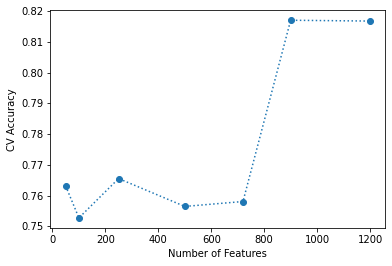

In [ ]:
draw_score(knn)

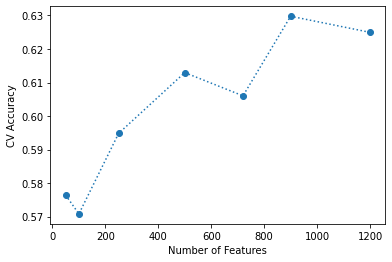

In [ ]:
draw_score(svm)

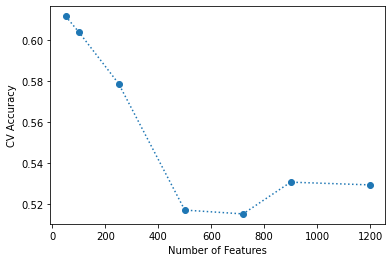

In [ ]:
draw_score(lr)

Feature set with 900 features gives the best or near-best performance in all four algorithms. Therefore, I will continue with this feature set.

In [ ]:
# Add new train set with 900 features to DataFrame
new_train_df = pd.DataFrame(feature_sets[5], columns=feature_names_set[5])
new_train_df.shape

(3749, 900)

# Hyperparameter Search

Decision Tree Classifier

In [ ]:
param_grid = [
  {'model__min_samples_leaf': [5, 10, 25, 45],
   'model__max_depth': [5, 10, 15, 25, 40]
  }
]

tree_results = GridSearchCV(tree, param_grid, refit=True, cv=3)
tree_results.fit(new_train_df, train_df_target)

print("Best Parameters:", tree_results.best_params_)
print("Best Score:", tree_results.best_score_)

Best Parameters: {'model__max_depth': 25, 'model__min_samples_leaf': 10}
Best Score: 0.8559585801974913


K-Nearest Neighbor

In [ ]:
param_grid = [
  {'n_neighbors': [5, 8, 12, 15, 20],
   'weights': ["uniform", "distance"]
   }
]

knn_results = GridSearchCV(knn, param_grid, refit=True, cv=3)
knn_results.fit(new_train_df, train_df_target)

print("Best Parameters:", knn_results.best_params_)
print("Best Score:", knn_results.best_score_)

Best Parameters: {'n_neighbors': 8, 'weights': 'distance'}
Best Score: 0.8178171337069656


Support Vector Machine

In [ ]:
param_grid = [
  {'model__C': [0.01, 0.1, 1, 10, 100]}
]

svm_results = GridSearchCV(svm, param_grid, refit=True, cv=3)
svm_results.fit(new_train_df, train_df_target)

print("Best Parameters:", svm_results.best_params_)
print("Best Score:", svm_results.best_score_)

Best Parameters: {'model__C': 10}
Best Score: 0.6407043501467841


Logistic Regression

In [ ]:
lr_results = GridSearchCV(lr, param_grid, refit=True, cv=3)
lr_results.fit(new_train_df, train_df_target)

print("Best Parameters:", lr_results.best_params_)
print("Best Score:", lr_results.best_score_)

Best Parameters: {'model__C': 0.01}
Best Score: 0.6126953829730452


Hyperparameter search significantly increased the cross validation scores of the estimators.

# Ensembling

Since I wanted to use probability values in ensembling, I changed the probability parameter to true in SVM. Using the probability=True parameter in the SVM significantly increases the execution time. Because of that, I did not initialize it at first.

In [ ]:
svm = Pipeline([('scaling', StandardScaler()), ('model', SVC(C=10, probability=True))])

ensemble = [('tree', tree_results.best_estimator_), ('knn', knn_results.best_estimator_), ('svm', svm), ('lr', lr_results.best_estimator_)]
classifier = VotingClassifier(estimators=ensemble, voting='soft')

In [ ]:
classifier.fit(new_train_df, train_df_target)

VotingClassifier(estimators=[('tree',
                              Pipeline(steps=[('scaling', StandardScaler()),
                                              ('model',
                                               DecisionTreeClassifier(max_depth=25,
                                                                      min_samples_leaf=10))])),
                             ('knn',
                              KNeighborsClassifier(n_neighbors=8,
                                                   weights='distance')),
                             ('svm',
                              Pipeline(steps=[('scaling', StandardScaler()),
                                              ('model',
                                               SVC(C=10, probability=True))])),
                             ('lr',
                              Pipeline(steps=[('scaling', StandardScaler()),
                                              ('model',
                                               Logisti

In [ ]:
print("Ensemble Score on Test Set:", classifier.score(test_df[feature_names_set[5]], test_df_target))

Ensemble Score on Test Set: 0.8808


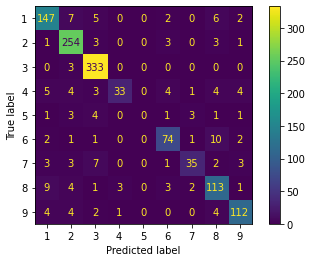

In [ ]:
ConfusionMatrixDisplay.from_estimator(classifier, test_df[feature_names_set[5]], test_df_target)

We can observe that ensemble's score on the test set is significantly higher than the models with the default parameters and the models trained with the best parameters after hyperparameter search.